# <B> Anormaly Detection based on RCF with Kinesis stream </B>
* Container: codna_python3

## This is from https://github.com/aws-samples/amazon-sagemaker-anomaly-detection-with-rcf-and-deepar

## RCF
: https://hiddenbeginner.github.io/paperreview/2021/07/14/rrcf.html

## AutoReload

In [1]:
%load_ext autoreload
%autoreload 2

## parameter store 설정

In [2]:
import boto3
from utils.ssm import parameter_store

In [3]:
strRegionName=boto3.Session().region_name
pm = parameter_store(strRegionName)
strPrefix = pm.get_params(key="PREFIX")

## pramamters for tasks

In [4]:
account_id = pm.get_params(key="-".join([strPrefix, "ACCOUNT-ID"]))
defaulut_bucket = pm.get_params(key="-".join([strPrefix, "BUCKET"]))
sagemaker_role = pm.get_params(key="-".join([strPrefix, "SAGEMAKER-ROLE-ARN"]))
s3_data_path = pm.get_params(key="-".join([strPrefix, "S3-DATA-PATH"]))

In [5]:
print (f"prefix: {strPrefix}")
print (f"account_id: {account_id}")
print (f"defaulut_bucket: {defaulut_bucket}")
print (f"sagemaker_role: {sagemaker_role}")
print (f"s3_data_path: {s3_data_path}")

prefix: ad-ts
account_id: 419974056037
defaulut_bucket: sm-anomaly-detection
sagemaker_role: arn:aws:iam::419974056037:role/service-role/AmazonSageMaker-ExecutionRole-20221206T163436
s3_data_path: s3://sm-anomaly-detection/data


## 1. Data manipulation

In [6]:
import os
import pandas as pd
from utils.util import plot_click_w_fault_and_res, plot_click_w_fault_res_ad, plot_click_w_ad_exp

* load data and derive features

In [7]:
clicks_1T = pd.read_csv(os.path.join(s3_data_path, "clicks_1T.csv"), parse_dates=["timestamp"]).set_index("timestamp")
clicks_1T['residual'] = clicks_1T['click'] - clicks_1T['user'] 
clicks_1T['fault'] = pd.read_csv(os.path.join(s3_data_path, "fault_label_1T.csv"), header=None).values[0] ## label 

In [8]:
print (f'data shape: {clicks_1T.shape}')
print (f'timestamp min: {clicks_1T.index.min()}, max: {clicks_1T.index.max()}')

data shape: (12960, 5)
timestamp min: 2020-07-07 00:00:00, max: 2020-07-15 23:59:00


* visualization

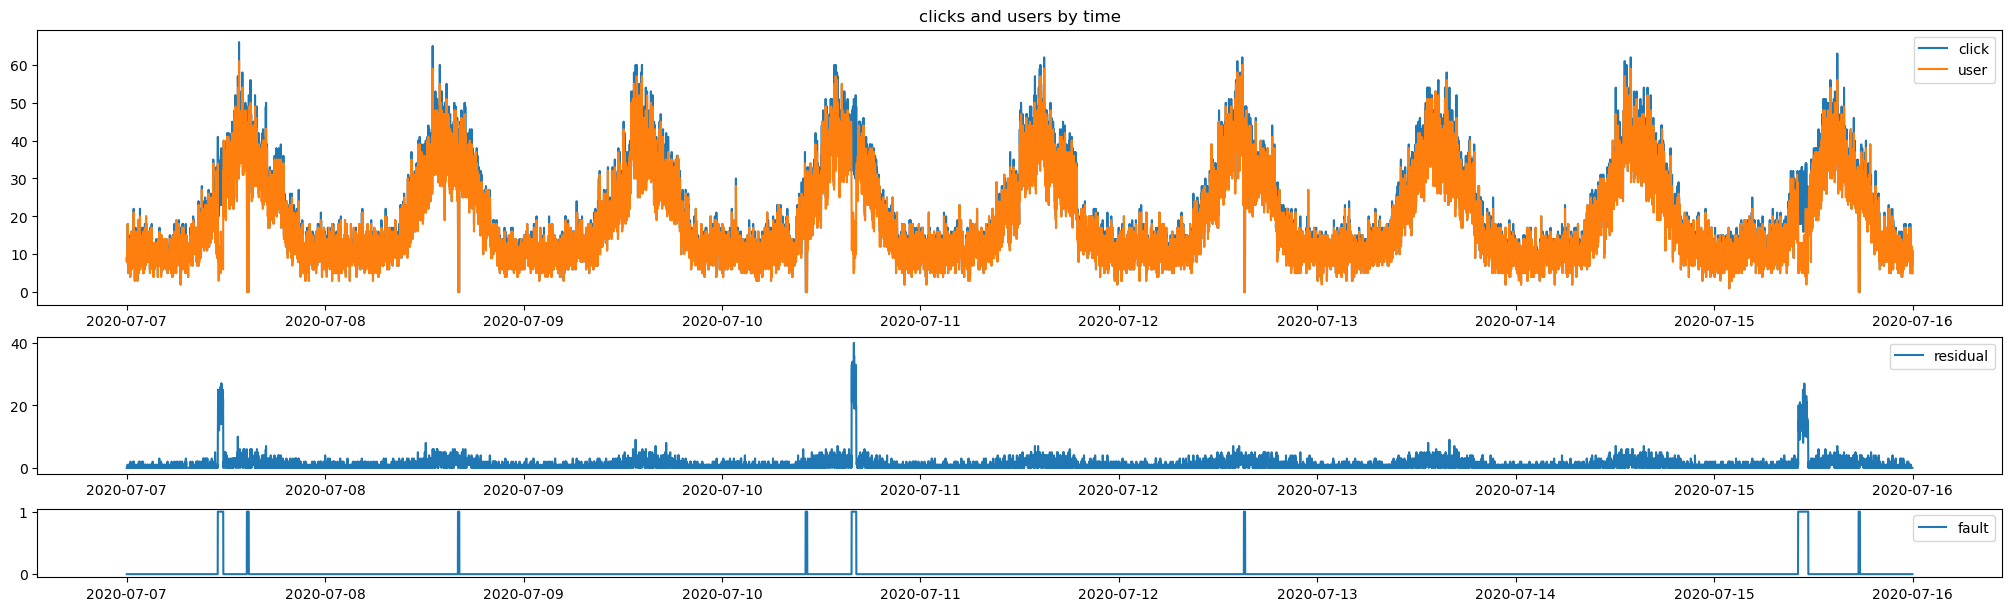

In [9]:
plot_click_w_fault_and_res(clicks_1T)

## 2. Creating Kinesis streams

We need to create below Kinesis resources. 
- 2 Kinesis Data Streams : `clickstream_input`, `clickstream_output`
- 1 Kinesis Analytics Application : `Clickstream-analytics-rcf-explanation`

![](imgs/architecture.png)

Since we use boto3 SDK to create all aws resource we use, you don't need to visit AWS console in this lab. But you may check the status or results in the console intermitantly during the process.


### 2-1. Create Kinesis data streams

First, we create 2 Kinesis data streams that serves as a short term streaming store for clickstreams. The throughput of an Amazon Kinesis data stream is determined by the number of shards within the data stream. We will use 1 for this example. You can calculate the initial number of shards (number_of_shards) the data stream needs using the following formula:
following formula:
```
 number_of_shards = max (incoming_write_bandwidth_in_KB/1000, outgoing_read_bandwidth_in_KB/2000)
```

In [10]:
from utils import kinesis
ks = kinesis.kinesis_handler()

This is a Kinesis handler.


* create streams

In [11]:
data_streams = [
    {"name":"clickstream_input",
     "shard_count": 1,
     "stream_mode": "PROVISIONED"
    },
    {"name":"clickstream_output",
     "shard_count": 1,
     "stream_mode": "PROVISIONED"
    }
]
create_stream_result = ks.create_streams(
    data_streams=data_streams
)

In [12]:
input_stream_arn = create_stream_result["clickstream_input"]
output_stream_arn = create_stream_result["clickstream_output"]

print (f'input_stream_arn: {input_stream_arn}')
print (f'output_stream_arn: {output_stream_arn}')

input_stream_arn: arn:aws:kinesis:us-east-1:419974056037:stream/clickstream_input
output_stream_arn: arn:aws:kinesis:us-east-1:419974056037:stream/clickstream_output


* increase retention period
    * https://docs.aws.amazon.com/streams/latest/dev/kinesis-extended-retention.html

In [13]:
ks.increase_stream_retention_period(
    stream_name="clickstream_input",
    retention_period = 72,
    stream_arn = input_stream_arn
)
ks.increase_stream_retention_period(
    stream_name="clickstream_output",
    retention_period = 72,
    stream_arn = output_stream_arn
)

Stream Retention Period was increased to 72 hours.
Stream Retention Period was increased to 72 hours.


True

### 2-2. Create IAM Role for kinesis

In [14]:
from utils.iam import iam_handler

In [15]:
iam = iam_handler()

In [16]:
listService = ["kinesisanalytics.amazonaws.com"]
strRoleName = strPrefix + "-KinesisAnalyticsRole"
listPolicyArn = [
    "arn:aws:iam::aws:policy/AmazonKinesisAnalyticsFullAccess",
    "arn:aws:iam::aws:policy/AmazonKinesisFullAccess",
]
strDescription="Role for Kinesis Analytics"

In [17]:
kinesisRoleArn = iam.create_role(
    listService=listService,
    strRoleName=strRoleName,
    listPolicyArn = listPolicyArn,
    strDescription=strDescription
)
print (f'KINESIS-ANALYTICS-ROLE-ARN: {kinesisRoleArn}')

== CREATE ROLE ==
  Role Name: [ad-ts-KinesisAnalyticsRole] is already exist!!, so, this will be deleted and re-created.
{'ResponseMetadata': {'RequestId': 'ad0211a8-7ff9-4cfe-a0f2-5091ec067266', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'ad0211a8-7ff9-4cfe-a0f2-5091ec067266', 'content-type': 'text/xml', 'content-length': '212', 'date': 'Fri, 28 Apr 2023 05:52:21 GMT'}, 'RetryAttempts': 0}}
arn:aws:iam::aws:policy/AmazonKinesisFullAccess
{'ResponseMetadata': {'RequestId': 'dc3f86a5-b187-4c9c-9985-2a37303462d6', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'dc3f86a5-b187-4c9c-9985-2a37303462d6', 'content-type': 'text/xml', 'content-length': '212', 'date': 'Fri, 28 Apr 2023 05:52:21 GMT'}, 'RetryAttempts': 0}}
arn:aws:iam::aws:policy/AmazonKinesisAnalyticsFullAccess
  Service name: ['kinesisanalytics.amazonaws.com'], 
  Role name: ad-ts-KinesisAnalyticsRole, 
  Policys: ['arn:aws:iam::aws:policy/AmazonKinesisAnalyticsFullAccess', 'arn:aws:iam::aws:policy/Am

### 2-3. Creating the Kinesis Data Analytics Application


We will configure Kinesis Data Analytics application to process the Kinesis data stream we created as the streaming source. You can add SQL and the destination stream in Kinesis Analytics with the code below. The parameters of the RANDOM_CUT_FOREST_WITH_EXPLANATION function are defined as numberOfTrees, subSampleSize, timeDecay, shingleSize, and withDirectionality.

* **numberOfTrees** : is the number of random cut trees in the forest. 
* **subSampleSize** : is the size of the random sample that you want the algorithm to use when constructing each tree
* **timeDecay** : decides how much of the recent past to consider when computing an anomaly score
* **shingleSize** : is the size of the consecutive sequence of the most recent records. For example, a shingleSize of 10 at time t corresponds to a vector of the last 10 records received up to and including time t. The algorithm treats this sequence as a vector over the last shingleSize number of records. If you set the shingleSize too small, the algorithm is more susceptible to minor fluctuations in the data, leading to high anomaly scores for records that are not anomalous.
If you set the shingleSize too large, it might take more time to detect anomalous records because there are more records in the shingle that are not anomalous. It also might take more time to determine that the anomaly has ended.
![](imgs/shingling_resize.png)
* **withDirectionality** : When set to true, it tells you the direction in which each individual dimension makes a contribution to the anomaly score. It also provides the strength of the recommendation for that directionality.

In this sample code, we set timeDecay as 4,320 (=60x24x3) which means we will take previous 3 days events into consideration. 

In [35]:
import sys
import time
from pprint import pprint

In [36]:
%%writefile random_cut_forest_with_explanation.sql

-- ** Anomaly detection **
-- Compute an anomaly score for each record in the source stream using Random Cut Forest
-- Creates a temporary stream and defines a schema
                                
CREATE OR REPLACE STREAM "TEMP_STREAM" (
   "TIMESTAMPS"          TIMESTAMP,
   "URLS"                INTEGER,
   "USERS"               INTEGER,
   "CLICKS"              INTEGER,
   "RESIDUALS"           INTEGER,
   "ANOMALY_SCORE"       DOUBLE,
   "ANOMALY_EXPLANATION" varchar(512));
-- Creates an output stream and defines a schema
CREATE OR REPLACE STREAM "DESTINATION_SQL_STREAM" (
   "TIMESTAMPS"          TIMESTAMP,
   "URLS"                INTEGER,
   "USERS"               INTEGER,
   "CLICKS"              INTEGER,
   "RESIDUALS"           INTEGER,
   "ANOMALY_SCORE"       DOUBLE,
   "ANOMALY_EXPLANATION" varchar(512));


-- RANDOM_CUT_FOREST anomaly score is a number between 0 and LOG2(subSampleSize)
-- See RANDOM_CUT_FOREST anomaly score explanation https://forums.aws.amazon.com/message.jspa?messageID=751928
-- Normalize the "ANOMALY_SCORE" by dividing it by LOG2(subSampleSize)
--   "shingleSize": 4, 24, 48
--    "numberOfTrees" : 100, 200

CREATE OR REPLACE PUMP "STREAM_PUMP" AS INSERT INTO "TEMP_STREAM"
SELECT STREAM "TIMESTAMPS", "URLS", "USERS", "CLICKS", "RESIDUALS", "ANOMALY_SCORE", "ANOMALY_EXPLANATION" FROM
  TABLE(RANDOM_CUT_FOREST_WITH_EXPLANATION(
    CURSOR(SELECT STREAM * FROM "SOURCE_SQL_STREAM_001"), -- inputStream
    256, -- numberOfTrees
    512, -- subSampleSize
    4320, -- timeDecay (60m x 24h x 3d) (default 100000)
    4, -- shingleSize
    true -- withDirectionality
  )
);

CREATE OR REPLACE PUMP "OUTPUT_PUMP" AS INSERT INTO "DESTINATION_SQL_STREAM"
SELECT STREAM * FROM "TEMP_STREAM"
ORDER BY FLOOR("TEMP_STREAM".ROWTIME TO SECOND), ANOMALY_SCORE DESC;

Overwriting random_cut_forest_with_explanation.sql


In [37]:
ks_analytics = kinesis.kinesis_analytics_handler()

This is a Kinesis Analytics handler.


In [38]:
input_stream_arn, kinesisRoleArn

('arn:aws:kinesis:us-east-1:419974056037:stream/clickstream_input',
 'arn:aws:iam::419974056037:role/ad-ts-KinesisAnalyticsRole')

In [39]:
application_name = 'clickstream-analytics-rcf-explanation-{}'.format(int(time.time()))
application_code = open('random_cut_forest_with_explanation.sql', "r").read()
inputs=[
    {
        'NamePrefix': 'SOURCE_SQL_STREAM',
        'KinesisStreamsInput': {
            'ResourceARN': input_stream_arn,
            'RoleARN': kinesisRoleArn
        },
        'InputSchema': {
            'RecordFormat': {
                'RecordFormatType': 'JSON',
                'MappingParameters': {
                    'JSONMappingParameters': {
                        'RecordRowPath': '$'
                    },
                }
            },
            'RecordEncoding': 'UTF-8',
            'RecordColumns': [
                        {
                            "SqlType": "TIMESTAMP",
                            "Name": "TIMESTAMPS",
                            "Mapping": "$.timestamp"
                        },
                        {
                            "SqlType": "INTEGER",
                            "Name": "URLS",
                            "Mapping": "$.page"
                        },
                        {
                            "SqlType": "INTEGER",
                            "Name": "USERS",
                            "Mapping": "$.user"
                        },
                        {
                            "SqlType": "INTEGER",
                            "Name": "CLICKS",
                            "Mapping": "$.click"
                        },
                        {
                            "SqlType": "INTEGER",
                            "Name": "RESIDUALS",
                            "Mapping": "$.residual"
                        }
            ],
            "RecordFormat": {
                "MappingParameters": {
                    'JSONMappingParameters': {
                        'RecordRowPath': '$'
                    },
                },
                "RecordFormatType": "JSON"
              }
        }
    },
]
outputs=[
    {
        'Name': 'DESTINATION_SQL_STREAM',
        'DestinationSchema': {
            'RecordFormatType': 'JSON'
        },
        "KinesisStreamsOutput": {
            "ResourceARN": output_stream_arn,
            "RoleARN": kinesisRoleArn
        }
    },
]

In [40]:
ks_analytics.create_application(
    application_name=application_name,
    application_code=application_code,
    inputs=inputs,
    outputs=outputs
)

kinesis application "clickstream-analytics-rcf-explanation-1682661574" was created successfully!.


True

### 2-4. Starting the Kinesis Data Analytics Application

Start the Amazon Kinesis Analytics application. After the application starts, it begins consuming the input data, processes it, and writes the output to the configured destination.    

In [41]:
ks_analytics.start_application(
    application_name=application_name
)

current status: STARTING
Starting .........................................RUNNING
kinesis application "clickstream-analytics-rcf-explanation-1682661574" start!!


True

## 3. Sending Input streams

### 3-1. Data Preparation
We use aggagated timeseries as input data, which have 4 features of the number of visited sites, the number of visitors, the numbor of clicks, and residuals of clicks and users in 1 minute.

In [42]:
import json
import random
import awswrangler as wr
from operator import itemgetter

In [43]:
clicks_1T_wt = clicks_1T.drop(['fault'],axis=1).reset_index()

### 3-2. Sending data
<!-- Similar to streaming data in real-time, we put clickstreams into Kinesis Data Analytics through Kinesis Data Stream by one record using For statement. Anomaly scores and explanations will be added to clickstreams through Kinesis analytics. -->
Now let's send the data to the Kiensis input data stream.  

By executing below code, you will:  

1) Send clickstream data into Kinesis data stream (`clickstream_input`).    
2) Write the anomaly score of output stream(`clickstream_output`) in the S3.  
3) Append the anomaly score to the `result` list to check the result.  

We used the APIs in Kinesis:
- [put_record](https://docs.aws.amazon.com/kinesis/latest/APIReference/API_PutRecord.html) - in following cell (inside the `for` loop)
- [get_records](https://docs.aws.amazon.com/kinesis/latest/APIReference/API_GetRecords.html) - in previous cell (s3_sink() function)

You can refer to the [Kinesis developer guide](https://docs.aws.amazon.com/streams/latest/dev/building-producers.html) for more information.

Running next cell takes 3~ 5 minutes. 

**NOTE** - _Please note that we send entire clickstream dataset at once. If it were real production environment, we need to wait whole 9 days to see the results. Instead, since the purpose of this lab is to see the Kinesis RCF function, we will send all streams at once by just repeating put_record() function for all dataset records._

* get shard iterator (for moutput)

In [44]:
try:
    del shard_iterator
except: 
    pass

In [45]:
output_stream_name = "clickstream_output"
shard_iterator = ks.get_shard_iterator(
    stream_name=output_stream_name,
)

* sending data to input stream

In [46]:
input_stream_name = "clickstream_input"
rnd=random.random()
listCols = clicks_1T_wt.columns

for idx, tupleRow in enumerate(clicks_1T_wt.itertuples(index=False)):  
    
    kinesis_data = {}
    
    for strCol in listCols:
        if strCol == "timestamp": value = str(getattr(tupleRow, strCol))
        else:value = int(getattr(tupleRow, strCol))
        kinesis_data[strCol] = value
        
    kinesis_data = json.dumps(kinesis_data)
    ks.put_record(
        stream_name=input_stream_name,
        data=kinesis_data,
        partition_key=str(rnd)
    )
    
    if idx % 1000 == 0:
        print (f'idx: {idx}')
    #if idx > 300: break

print (f'sending data: {idx+1}')      

idx: 0
idx: 1000
idx: 2000
idx: 3000
idx: 4000
idx: 5000
idx: 6000
idx: 7000
idx: 8000
idx: 9000
idx: 10000
idx: 11000
idx: 12000
sending data: 12960


* get and write results

In [47]:
# This function saves the results from Kinesis Analytics into the S3
def s3_sink(shard_iterator):
    rows = []
    response = ks.get_records(
        shard_iterator=shard_iterator
    )
    records = response["Records"]

    try:
        while len(records) > 0:
            parsed_records = []
            for rec in records:
                parsed_record = json.loads(rec["Data"])
                parsed_records.append(parsed_record)
            rows.extend(parsed_records)
            time.sleep(1)
            shard_iterator = response["NextShardIterator"]
            response = ks.get_records(
                shard_iterator=shard_iterator
            )
            records = response["Records"]
        
        rows = sorted(rows, key=itemgetter("TIMESTAMPS"), reverse=False)
        flag = rows[0]['TIMESTAMPS'].replace(":","-").replace(" ","-").replace(".","-")
        s3_save_path = 's3://{}/{}/{}'.format(defaulut_bucket, 'kinesis-analytics-rcf-scores', flag)
        wr.s3.to_csv(
           df=pd.DataFrame(rows),
           path=s3_save_path
        )
    except:
        sys.stdout.write("[ExpiredIteratorException] Iterator expired.")
        pass
    return rows

In [48]:
time.sleep(10) # wait for results

scores = []
score_raw = s3_sink(shard_iterator)
scores.extend(score_raw)
pdScores=pd.DataFrame(score_raw)

In [49]:
print (pdScores.shape)

(12960, 7)


* scores to pandas DF

  The explanation in the result provides the following values for each column in the record:

    * **Attribution score** : A nonnegative number that indicates how much this column has contributed to the anomaly score of the record
    * **Strength** : A nonnegative number representing the strength of the directional recommendation. 
    * **Directionality** : This is either HIGH if the value of the column is above the recently observed trend or LOW if it’s below the trend. During the learning phase, this defaults to LOW.
    
    * **anomaly score** = sum all Attribution scores

In [50]:
listCols = pdScores.columns
listRows = []
for tuplerow in pdScores.itertuples(index=False):
    dicRow = {}
    for strCol in listCols:
        value = getattr(tuplerow, strCol)
        
        if strCol == "ANOMALY_EXPLANATION":
            dicValues = eval(value)
            for key, value in dicValues.items():
                for name, score  in value.items():
                    if name != "DIRECTION": dicRow["_".join([key, name])] = float(score)
                    else: dicRow["_".join([key, name])] = str(score)
        else:
            dicRow[strCol] = value
    
    listRows.append(dicRow)
pdScores = pd.DataFrame(listRows).set_index("TIMESTAMPS")
pdScores['fault'] = list(clicks_1T['fault'])
pdScores = pdScores.rename(columns={"URLS":"url", "USERS":"user", "CLICKS":"click", "RESIDUALS":"residual"})

* Check the distribution of our anomaly score.

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

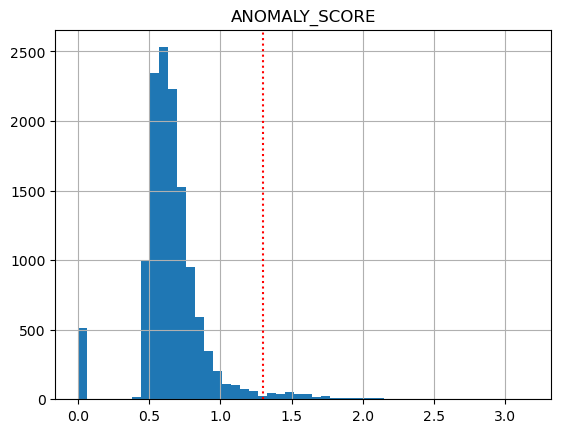

3 sigma threshoud = 1.2990537128019082


In [52]:
threshold = pdScores['ANOMALY_SCORE'].mean() + 2.5*pdScores['ANOMALY_SCORE'].std()

pdPlot = pd.DataFrame(pdScores['ANOMALY_SCORE'])
pdPlot.hist(bins=50)
plt.axvline(x=threshold, linestyle=':', c='r')
plt.annotate('threshold={}'.format(round(threshold,2)), xy=(threshold,6000), color='r')
plt.show()

print('3 sigma threshoud = {}'.format(threshold))

## 4. Plotting the Prediction

Plot the anomalous points detected by Kinesis RCF.

In [53]:
pdScores

,url,user,click,residual,ANOMALY_SCORE,URLS_DIRECTION,URLS_STRENGTH,URLS_ATTRIBUTION_SCORE,USERS_DIRECTION,USERS_STRENGTH,USERS_ATTRIBUTION_SCORE,CLICKS_DIRECTION,CLICKS_STRENGTH,CLICKS_ATTRIBUTION_SCORE,RESIDUALS_DIRECTION,RESIDUALS_STRENGTH,RESIDUALS_ATTRIBUTION_SCORE,fault
TIMESTAMPS,,,,,,,,,,,,,,,,,,
2020-07-07 00:00:00.000,4,9,9,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-07-07 00:01:00.000,7,8,8,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-07-07 00:02:00.000,4,9,9,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-07-07 00:03:00.000,6,11,11,0,0.000000,LOW,0.0000,0.0000,LOW,0.0000,0.0000,LOW,0.0000,0.0000,LOW,0.0000,0.0000,0
2020-07-07 00:04:00.000,4,9,9,0,0.000000,LOW,0.0000,0.0000,LOW,0.0000,0.0000,LOW,0.0000,0.0000,LOW,0.0000,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-15 23:55:00.000,6,10,10,0,0.436908,HIGH,0.0028,0.1118,LOW,0.0013,0.1407,LOW,0.0070,0.1524,LOW,0.0006,0.0320,0
2020-07-15 23:56:00.000,5,12,12,0,0.434708,LOW,0.0044,0.0982,HIGH,0.0016,0.1462,LOW,0.0038,0.1578,LOW,0.0005,0.0326,0
2020-07-15 23:57:00.000,5,7,7,0,0.497560,HIGH,0.0018,0.1182,LOW,0.0102,0.1695,LOW,0.0154,0.1812,LOW,0.0001,0.0286,0


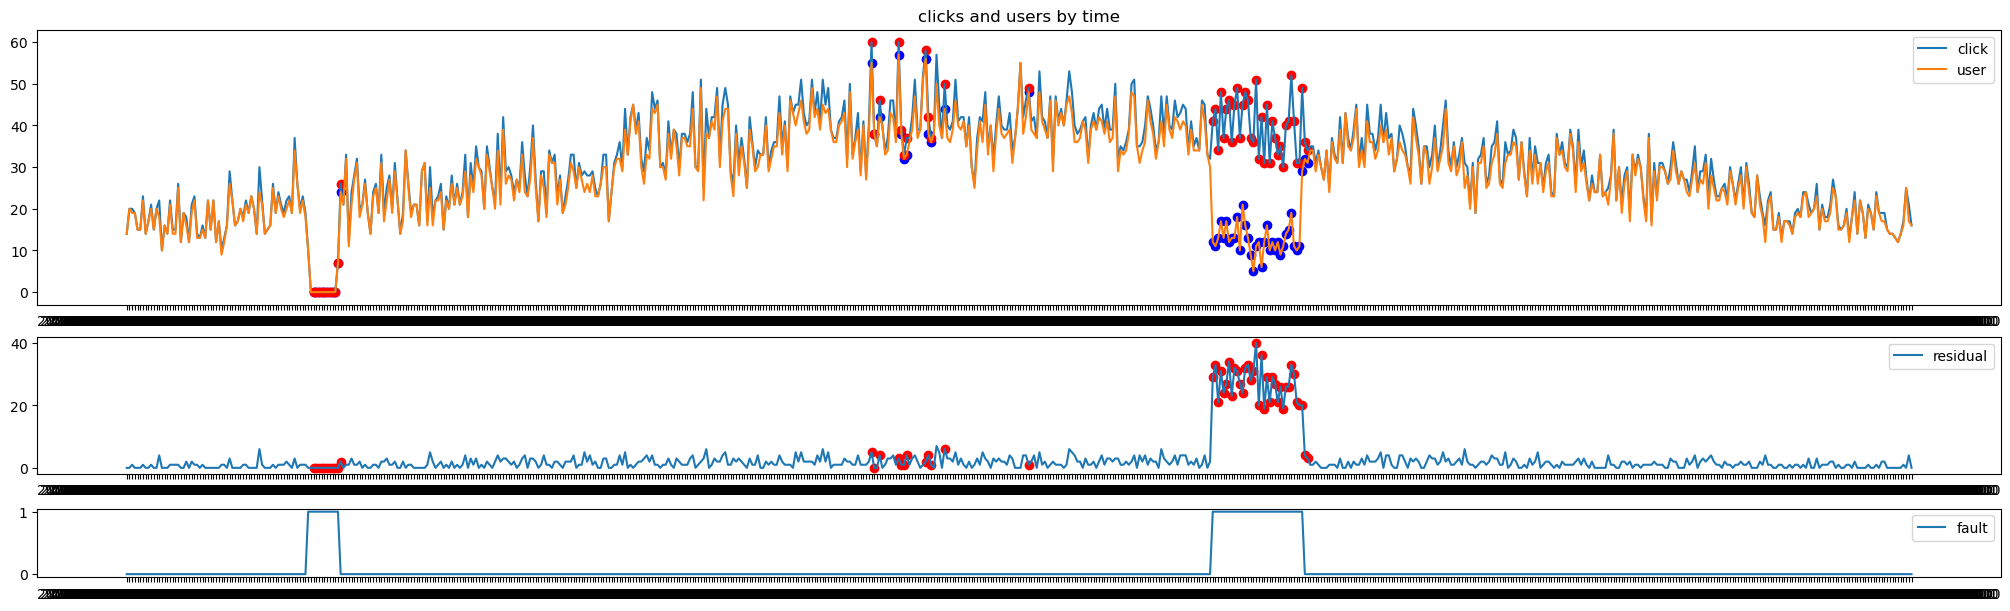

In [54]:
anomalous = pdScores.query("ANOMALY_SCORE > @threshold")
stime = "2020-07-10 09:00:00" # "2012-03-13 08:00:00"
etime = "2020-07-10 20:00:00" # "2012-03-13 20:00:00"
plot_click_w_fault_res_ad(pdScores, anomalous, threshold, start_dt=stime, end_dt=etime)

We can see more anmoalous points that exceed the threshold at the time of a system or program fault event.

Additinally, we have additional colomns which explain contribution of features. Plot the anomaly score and check which values most affected the anomaly score. 

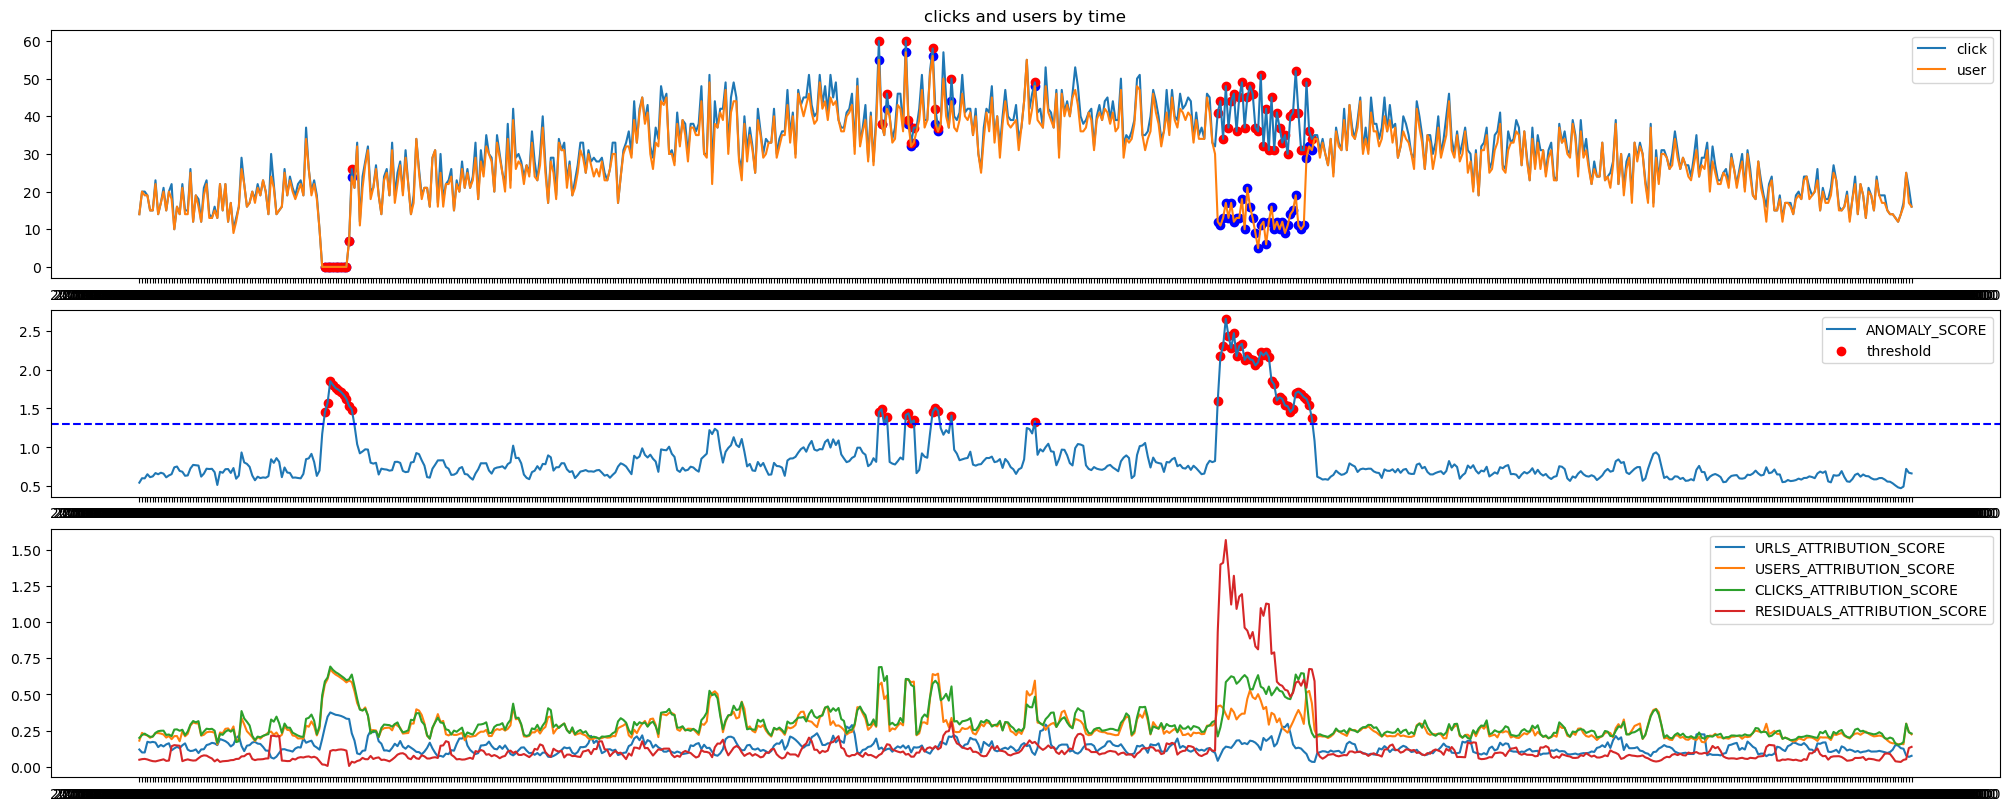

In [55]:
plot_click_w_ad_exp(pdScores, anomalous, threshold, start_dt=stime, end_dt=etime)

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


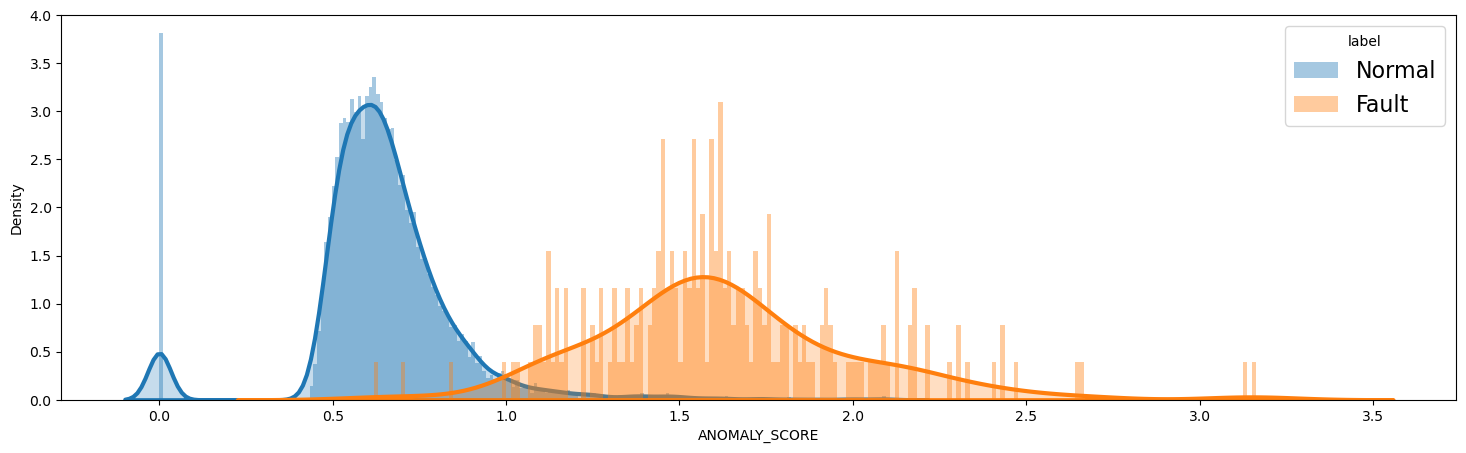

In [56]:
plt.figure(figsize = (18,5))
fault_types = [0, 1]
for fault_type in fault_types:
    
    if fault_type == 0: label = "Normal"
    else: label = "Fault"
    sns.distplot(
        pdScores[pdScores.fault==fault_type]["ANOMALY_SCORE"],
        hist=True,
        kde=True,
        kde_kws={"shade":True, "linewidth":3},
        label=label,
        bins=200
    )
plt.legend(prop={"size":16}, title = "label")

In [57]:
pdAnomal = pdScores.query("ANOMALY_SCORE > @threshold")[["ANOMALY_SCORE", "URLS_ATTRIBUTION_SCORE", "USERS_ATTRIBUTION_SCORE", \
                                                         "CLICKS_ATTRIBUTION_SCORE", "RESIDUALS_ATTRIBUTION_SCORE"]]

* performance metric

In [58]:
precision = pdScores.query("fault == 1 and ANOMALY_SCORE > @threshold").shape[0] / pdScores.query("ANOMALY_SCORE > @threshold").shape[0]
recall = pdScores.query("fault == 1 and ANOMALY_SCORE > @threshold").shape[0] / pdScores.query("fault == 1").shape[0]
f1_score = 2*(precision*recall)/(precision+recall)

In [59]:
print (f'Precision: {precision}')
print (f'Recall: {recall}')
print (f'f1_score: {f1_score}')

Precision: 0.4885057471264368
Recall: 0.8374384236453202
f1_score: 0.617059891107078


## Save parameters to SSM

In [60]:
pm.put_params(key="-".join([strPrefix, "STREAM-ARN-INPUT"]), value=input_stream_arn, overwrite=True)
pm.put_params(key="-".join([strPrefix, "STREAM-ARN-OUTPUT"]), value=output_stream_arn, overwrite=True)
pm.put_params(key="-".join([strPrefix, "KINESIS-ANALYTICS-ROLE-ARN"]), value=kinesisRoleArn, overwrite=True)
pm.put_params(key="-".join([strPrefix, "KINESIS-APP-NAME"]), value=application_name, overwrite=True)

'Store suceess'

## Delete resources

* delete streams

In [61]:
ks.delete_stream(
    stream_name=input_stream_name,
    consumer_deletion=False,
    stream_arn=input_stream_arn
)
ks.delete_stream(
    stream_name=output_stream_name,
    consumer_deletion=False,
    stream_arn=output_stream_arn
)

Stream "clickstream_input" was deleted successfully!.
Stream "clickstream_output" was deleted successfully!.


True

* delete application 

In [62]:
ks_analytics.stop_application(
    application_name=application_name
)
ks_analytics.delete_application(
    application_name=application_name
)

Stopping ....
STOP: kinesis application "clickstream-analytics-rcf-explanation-1682661574"
kinesis application "clickstream-analytics-rcf-explanation-1682661574" was deleted successfully!.
